In [68]:
import pysam
import argparse
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def count_X_Y_for_bam(bam_file_path):

    # read in the bam file 
    bam_file = pysam.AlignmentFile(bam_file_path, "rb")
    
    # initialize counts for chrX and chrY
    chrX_count = 0
    chrY_count = 0

    # count reads on chrX and chrY
    for read in bam_file.fetch("chrX"):
        if not read.is_unmapped:
            chrX_count += 1
    
    for read in bam_file.fetch("chrY"):
        if not read.is_unmapped:
            chrY_count += 1

    return([chrX_count, chrY_count])

In [22]:
directories = [d for d in os.listdir(".") if os.path.isdir(d)]

# filter to only the human directories
directories = [d for d in directories if d not in ['.ipynb_checkpoints', 'H7CM-D328-2', 'H7CM-D328-1', 
                                     'H7CM-D20-2', 'H7CM-D20-1', 'fragment_files']]

len(directories)

22

In [25]:
bam_files = [d + '/counts/outs/possorted_bam.bam' for d in directories]

In [36]:
%%time

X_count_list = list()
Y_count_list = list()

for bam_file in bam_files:
    X_count, Y_count = count_X_Y_for_bam(bam_file)
    X_count_list.append(X_count)
    Y_count_list.append(Y_count)

[W::hts_idx_load3] The index file is older than the data file: LV-NDRI15755_10k/counts/outs/possorted_bam.bam.bai
[W::hts_idx_load3] The index file is older than the data file: Fetal-OFT-14wk/counts/outs/possorted_bam.bam.bai


CPU times: user 3min 51s, sys: 5.33 s, total: 3min 56s
Wall time: 4min 9s


In [54]:
# create df 

chrX_Y_counts_df = pd.DataFrame({'sample_name': directories, 
                                'count_X': X_count_list, 
                                'count_Y': Y_count_list})

In [59]:
chrX_Y_counts_df['total_sex_chr_counts'] = chrX_Y_counts_df['count_X'] + chrX_Y_counts_df['count_Y']
chrX_Y_counts_df['ratio_Y'] = chrX_Y_counts_df['count_Y'] / chrX_Y_counts_df['total_sex_chr_counts']

In [60]:
donor_metadata = pd.read_csv("01_metadata.txt", delim_whitespace=True)
donor_metadata = donor_metadata.rename(columns = {'sample': 'sample_name'})
donor_metadata = donor_metadata[["sample_name", "sex"]]

In [63]:
merged_df = chrX_Y_counts_df.merge(donor_metadata)
merged_df

,sample_name,count_X,count_Y,total_sex_chr_counts,ratio_Y,sex
0,LV-K1488-run-1,4113419,825884,4939303,0.167207,male
1,LV-K1647-run-2,3379757,652835,4032592,0.161890,male
2,Fetal-LRV-2,6480742,1107592,7588334,0.145960,Unknown
3,LV-K1584-run-2,6052165,1494987,7547152,0.198086,male
4,Fetal-heart-8wk,24328686,3852291,28180977,0.136698,Unknown
5,LV-K1485-run-1,3703234,758337,4461571,0.169971,male
6,Fetal-LV-2,11772109,484480,12256589,0.039528,Unknown
7,Fetal-LRV-14wk,10422836,1080227,11503063,0.093908,Unknown
8,Fetal-OFT-2,8914049,2046586,10960635,0.186721,Unknown
9,Fetal-wholeHeart-10wk,12603051,2247423,14850474,0.151337,Unknown


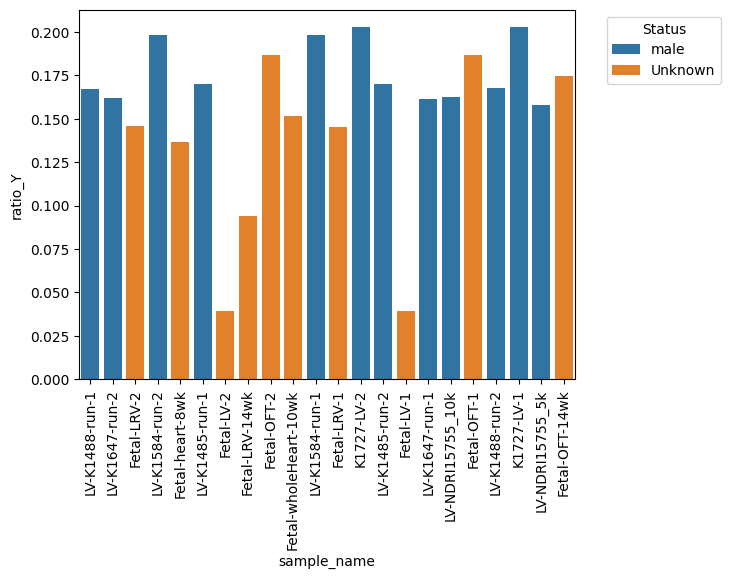

In [72]:
sns.barplot(data = merged_df, x = 'sample_name', y = 'ratio_Y', hue = 'sex')
plt.xticks(rotation = 90)
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Based on the known sex donors, it is likely that the Fetal-LV-1 and Fetal-LV-2, which come from the same donor are female. Fetal-LRV-14wk is still likely male.

### We will perform the same for the fragment files

In [85]:
fragment_dir = "fragment_files/"
fragment_files = [f for f in os.listdir(fragment_dir) if f.endswith(".gz")]

In [83]:
def count_X_Y_for_bed(bed_file_path):
    # Read the BED file as a DataFrame, assuming it has no header
    bed_df = pd.read_csv(bed_file_path, compression='gzip', sep='\t', header=None, usecols=[0], names=['chromosome'])

    # Count occurrences of chrX and chrY
    chrX_count = (bed_df['chromosome'] == 'chrX').sum()
    chrY_count = (bed_df['chromosome'] == 'chrY').sum()

    return [chrX_count, chrY_count]

In [87]:
%%time
X_count_bed_list = list()
Y_count_bed_list = list()

for fragment_file in fragment_files:
    print(fragment_file)
    X_count, Y_count = count_X_Y_for_bed(fragment_dir + fragment_file)
    X_count_bed_list.append(X_count)
    Y_count_bed_list.append(Y_count)

LV-K1488-run-1_fragments.tsv.gz
H7CM-D20-2_fragments.tsv.gz
LV-K1647-run-2_fragments.tsv.gz
LV-K1584-run-1_fragments.tsv.gz
LV-K1647-run-1_fragments.tsv.gz
H7CM-D328-1_fragments.tsv.gz
H7CM-D20-1_fragments.tsv.gz
Fetal-OFT-2_fragments.tsv.gz
Fetal-LRV-1_fragments.tsv.gz
K1727-LV-2_fragments.tsv.gz
K1727-LV-1_fragments.tsv.gz
H7CM-D328-2_fragments.tsv.gz
LV-K1485-run-1_fragments.tsv.gz
Fetal-wholeHeart-10wk_fragments.tsv.gz
Fetal-LV-2_fragments.tsv.gz
LV-K1584-run-2_fragments.tsv.gz
LV-NDRI15755_5k_fragments.tsv.gz
LV-K1485-run-2_fragments.tsv.gz
Fetal-LV-1_fragments.tsv.gz
Fetal-LRV-2_fragments.tsv.gz
LV-K1488-run-2_fragments.tsv.gz
LV-NDRI15755_10k_fragments.tsv.gz
Fetal-LRV-14wk_fragments.tsv.gz
Fetal-OFT-14wk_fragments.tsv.gz
Fetal-heart-8wk_fragments.tsv.gz
Fetal-OFT-1_fragments.tsv.gz
CPU times: user 22min 40s, sys: 1min 19s, total: 24min
Wall time: 24min 6s


In [96]:
chrX_Y_counts_bed_df = pd.DataFrame({'sample_name': fragment_files, 
                                'count_X': X_count_bed_list, 
                                'count_Y': Y_count_bed_list})

In [103]:
chrX_Y_counts_bed_df['total_sex_chr_counts'] = chrX_Y_counts_bed_df['count_X'] + chrX_Y_counts_bed_df['count_Y']
chrX_Y_counts_bed_df['ratio_Y'] = chrX_Y_counts_bed_df['count_Y'] / chrX_Y_counts_bed_df['total_sex_chr_counts']

In [104]:
chrX_Y_counts_bed_df['sample_name'] = chrX_Y_counts_bed_df['sample_name'].str.replace("_fragments.tsv.gz", "")

In [105]:
merged_bed_df = chrX_Y_counts_bed_df.merge(donor_metadata)
merged_bed_df

,sample_name,count_X,count_Y,total_sex_chr_counts,ratio_Y,sex
0,LV-K1488-run-1,1599276,114428,1713704,0.066772,male
1,H7CM-D20-2,2598261,11121,2609382,0.004262,NaN
2,LV-K1647-run-2,1343436,103124,1446560,0.071289,male
3,LV-K1584-run-1,1481713,129175,1610888,0.080189,male
4,LV-K1647-run-1,1617790,123054,1740844,0.070686,male
5,H7CM-D328-1,2522316,13058,2535374,0.005150,NaN
6,H7CM-D20-1,2819099,10376,2829475,0.003667,NaN
7,Fetal-OFT-2,2914971,259367,3174338,0.081707,Unknown
8,Fetal-LRV-1,2208946,152194,2361140,0.064458,Unknown
9,K1727-LV-2,2558209,221856,2780065,0.079802,male


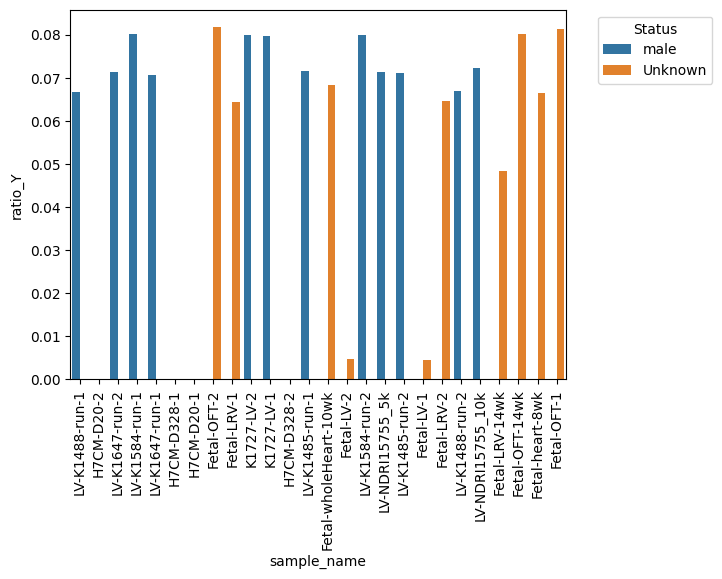

In [106]:
sns.barplot(data = merged_bed_df, x = 'sample_name', y = 'ratio_Y', hue = 'sex')
plt.xticks(rotation = 90)
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Investigate also the Ameen fragment files

In [110]:
Ameen_fragment_dir = "../fetal_datasets/fragment_files/Ameen_2022/"
Ameen_fragment_files = [f for f in os.listdir(Ameen_fragment_dir) if f.endswith(".gz")]
Ameen_fragment_files

['GSM5495103_F8_v2_fragments.tsv.gz',
 'GSM5495102_F6_v2_fragments.tsv.gz',
 'GSM5495104_F19_v2_fragments.tsv.gz']

In [111]:
Ameen_X_count_bed_list = list()
Ameen_Y_count_bed_list = list()

for fragment_file in Ameen_fragment_files:
    print(fragment_file)
    X_count, Y_count = count_X_Y_for_bed(fragment_dir + fragment_file)
    Ameen_X_count_bed_list.append(X_count)
    Ameen_Y_count_bed_list.append(Y_count)

GSM5495103_F8_v2_fragments.tsv.gz
GSM5495102_F6_v2_fragments.tsv.gz
GSM5495104_F19_v2_fragments.tsv.gz


In [112]:
Ameen_chrX_Y_counts_bed_df = pd.DataFrame({'sample_name': Ameen_fragment_files, 
                                'count_X': Ameen_X_count_bed_list, 
                                'count_Y': Ameen_Y_count_bed_list})

In [113]:
Ameen_chrX_Y_counts_bed_df['total_sex_chr_counts'] = Ameen_chrX_Y_counts_bed_df['count_X'] + Ameen_chrX_Y_counts_bed_df['count_Y']
Ameen_chrX_Y_counts_bed_df['ratio_Y'] = Ameen_chrX_Y_counts_bed_df['count_Y'] / Ameen_chrX_Y_counts_bed_df['total_sex_chr_counts']

In [114]:
Ameen_chrX_Y_counts_bed_df['sample_name'] = Ameen_chrX_Y_counts_bed_df['sample_name'].str.replace("_fragments.tsv.gz", "")

<Axes: xlabel='sample_name', ylabel='ratio_Y'>

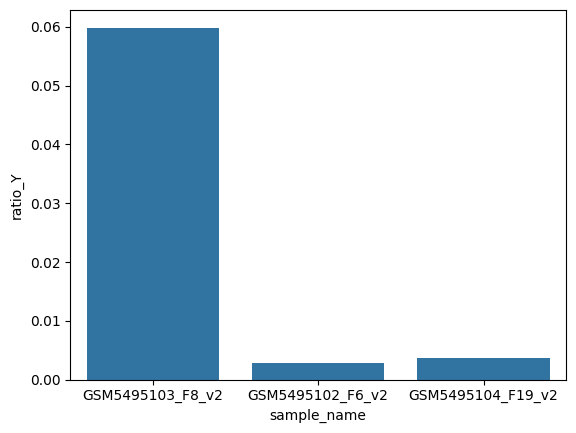

In [117]:
sns.barplot(data = Ameen_chrX_Y_counts_bed_df, x = 'sample_name', y = 'ratio_Y')

#### The bed file version seems to be better discriminate between male and females. Ideally, we would do this for all of the fragment files we have. Therefore, we will run this in the ND_D_fetal directory in a non-interactive script.